<a href="https://colab.research.google.com/github/nmarkin/Rec-Sys-Okko/blob/main/full_recsys_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Configuration

In [2]:
!pip install shap
!pip install lightfm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp39-cp39-linux_x86_64.whl size=889514 sha256=fb17f1db472cda6e29d6e44627d2bcf9743e2a0e379058bd43d70080f66a6a09
  Stored in directory: /root/.cache/pip/wheels/d8/65/93/6ac8180274dc2e8f86ff326be62da1dfa55dc158fd45faba7d
Successfully built lightfm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00


In [3]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
INTERACTIONS_PATH = '/Users/s.khalilbekov/Downloads/data_kion/interactions_df.csv'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/12a80lS3vXQOl6i6ENgz-WqWw3Wms0nqB/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MwPaye0cRi53czLqCnH0bOuvIhOeNlAx/view?usp=share_link'

# 1. Modules and functions

In [4]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. 1. Helper functions to avoid copy paste

In [5]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [6]:
# interactions data
interactions = pd.read_csv('interactions_df.csv')
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [7]:
# information about films etc
movies_metadata = read_csv_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.000,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.000,"зарубежные, приключения, комедии",США,NaN,16.000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.000,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.000,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [8]:
users_data = read_csv_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [9]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)

In [10]:
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [11]:
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [12]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00


In [13]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [14]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(3530674, 5) (665015, 5)


In [15]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2021-07-11 00:00:00


In [16]:
global_train = global_train.dropna().reset_index(drop = True)

In [17]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2451040, 5) (1079183, 5)


In [18]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(579382, 5)


In [19]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [20]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [21]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  539173
user features mapper length -  539173
movies mapper length -  13006
Users movie features mapper length -  13006


In [22]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [23]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [24]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [25]:
train_mat

<539173x13006 sparse matrix of type '<class 'numpy.int32'>'
	with 2451040 stored elements in COOrdinate format>

In [26]:
train_mat_weights

<539173x13006 sparse matrix of type '<class 'numpy.float32'>'
	with 2451040 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [27]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [28]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [29]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 713676, row number in matrix - 62


In [31]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

13006

In [32]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 1.2468398 ,  0.46109986, -1.4427844 , ..., -2.4233615 ,
        -2.0391545 , -2.0528052 ], dtype=float32),
 (13006,))

In [33]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([302,  20, 435,   5, 225, 410,  61, 146, 298, 232])

In [34]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [35]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,302,12173,Мстители: Финал
1,20,7626,Мстители: Война бесконечности
2,435,13018,Король лев (2019)
3,5,7571,100% волк
4,225,10942,Мстители
5,410,7210,Тор: Рагнарёк
6,61,4436,Ford против Ferrari
7,146,11310,Аладдин
8,298,13915,Вперёд
9,232,1785,Чёрная пантера


In [36]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 869219, row number in matrix - 675


In [37]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([-0.63678724, -0.9542297 , -3.0479631 , ..., -3.5099337 ,
        -3.3164275 , -2.474372  ], dtype=float32),
 (13006,))

In [38]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 222,  493,  682, 2935, 1390, 1065,  401,  255, 1651,  306])

In [39]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,222,676,Человек-невидимка
1,493,3620,Прочь
2,682,16361,Doom: Аннигиляция
3,2935,1090,Нерождённый
4,1390,2483,Очень страшное кино 5
5,1065,5838,"Дом, который построил Джек"
6,401,4696,Удивительное путешествие доктора Дулиттла
7,255,14431,Приворот. Чёрное венчание
8,1651,11231,Заклятье. Дом 32
9,306,9169,Взаперти


In [40]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

144739

In [41]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [42]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [43]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [44]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [45]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(1447390, 2)

In [46]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [47]:
test_preds.head()

,user_id,item_id,rank
0,646903,16361,1
0,646903,10440,2
0,646903,14359,3
0,646903,14431,4
0,646903,9169,5


In [48]:
test_preds['item_name'] = test_preds['item_id'].map(item_name_mapper)
test_preds.head()

,user_id,item_id,rank,item_name
0,646903,16361,1,Doom: Аннигиляция
0,646903,10440,2,Хрустальный
0,646903,14359,3,Проклятие ведьмы
0,646903,14431,4,Приворот. Чёрное венчание
0,646903,9169,5,Взаперти


In [49]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

1770

In [50]:
test_preds

,user_id,item_id,rank,item_name
0,646903,16361,1,Doom: Аннигиляция
0,646903,10440,2,Хрустальный
0,646903,14359,3,Проклятие ведьмы
0,646903,14431,4,Приворот. Чёрное венчание
0,646903,9169,5,Взаперти
...,...,...,...,...
144738,119646,142,6,Маша
144738,119646,12995,7,Восемь сотен
144738,119646,15297,8,Клиника счастья
144738,119646,13723,9,Левиафан


## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [51]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(77570, 8)

In [52]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(273964, 8)

In [53]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [54]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [55]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [56]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:           user_id       rank   total_dur  watched_pct     target
count  281064.000 281064.000   61873.000    61873.000 281064.000
mean   549086.281      5.303   18650.260       65.436      0.220
std    316291.294      2.884   38239.835       36.846      0.414
min        11.000      1.000     301.000        0.000      0.000
25%    275152.000      3.000    4003.000       25.000      0.000
50%    549268.000      5.000    7794.000       81.000      0.000
75%    822102.000      8.000   22556.000      100.000      0.000
max   1097521.000     10.000 3086101.000      100.000      1.000 
, TEST:           user_id      rank  total_dur  watched_pct    target
count   70470.000 70470.000  15697.000    15697.000 70470.000
mean   547030.832     5.304  18864.328       65.080     0.223
std    317485.117     2.890  35859.215       36.961     0.416
min       106.000     1.000    302.000        0.000     0.000
25%    271660.000     3.000   3889.000       25.000     0.000
50%    547130.500     5.000

In [57]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

In [58]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])


In [59]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])


In [60]:
print(cbm_train_set.shape, cbm_test_set.shape)

(281064, 16) (70470, 16)


In [61]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,208127,10464,4,Вирус страха,NaT,NaN,NaN,0,age_45_54,income_20_40,Ж,0.000,film,2020.000,NaN,16.000
1,10053,9728,4,Гнев человеческий,2021-07-12,3373.000,49.000,1,NaN,NaN,NaN,NaN,film,2021.000,NaN,18.000
2,1008910,11237,9,День города,NaT,NaN,NaN,0,age_35_44,income_60_90,Ж,1.000,film,2021.000,NaN,16.000
3,99996,15297,2,Клиника счастья,NaT,NaN,NaN,0,age_65_inf,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
4,943006,15297,10,Клиника счастья,2021-07-28,742.000,0.000,1,age_65_inf,income_20_40,Ж,0.000,series,2021.000,NaN,18.000


In [62]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [63]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(281064, 9) (70470, 9)


In [64]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,4,age_45_54,income_20_40,Ж,0.000,film,2020.000,NaN,16.000
1,4,NaN,NaN,NaN,NaN,film,2021.000,NaN,18.000
2,9,age_35_44,income_60_90,Ж,1.000,film,2021.000,NaN,16.000
3,2,age_65_inf,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
4,10,age_65_inf,income_20_40,Ж,0.000,series,2021.000,NaN,18.000


In [65]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [66]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [67]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6507734	test: 0.6513673	best: 0.6513673 (0)	total: 376ms	remaining: 31m 21s
1:	learn: 0.6172870	test: 0.6183966	best: 0.6183966 (1)	total: 644ms	remaining: 26m 50s
2:	learn: 0.5914911	test: 0.5930577	best: 0.5930577 (2)	total: 886ms	remaining: 24m 35s
3:	learn: 0.5708930	test: 0.5728683	best: 0.5728683 (3)	total: 1.11s	remaining: 23m 7s
4:	learn: 0.5545067	test: 0.5568538	best: 0.5568538 (4)	total: 1.42s	remaining: 23m 40s
5:	learn: 0.5417674	test: 0.5444326	best: 0.5444326 (5)	total: 1.67s	remaining: 23m 11s
6:	learn: 0.5317401	test: 0.5346595	best: 0.5346595 (6)	total: 1.94s	remaining: 23m 3s
7:	learn: 0.5245435	test: 0.5276957	best: 0.5276957 (7)	total: 2.19s	remaining: 22m 46s
8:	learn: 0.5181319	test: 0.5215400	best: 0.5215400 (8)	total: 2.46s	remaining: 22m 44s
9:	learn: 0.5136291	test: 0.5172276	best: 0.5172276 (9)	total: 2.69s	remaining: 22m 22s
10:	learn: 0.5099553	test: 0.5137618	best: 0.5137618 (10)	total: 2.93s	remaining: 22m 9s
11:	learn: 0.5065050	test: 0.5104

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [68]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

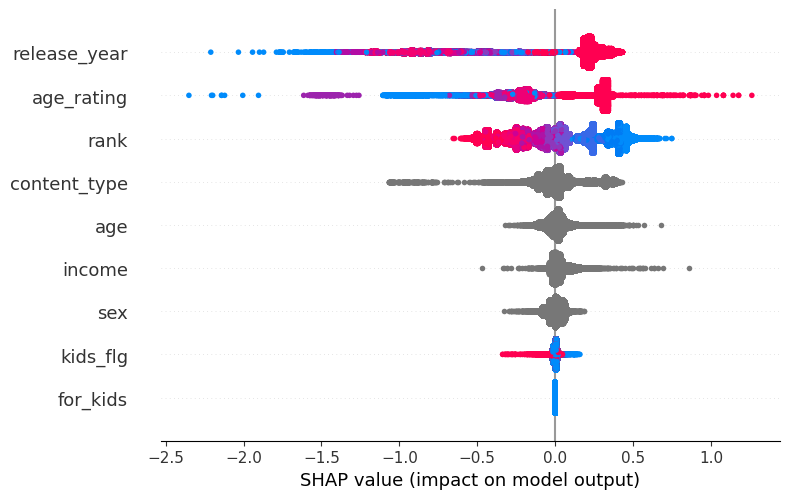

In [69]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [70]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [71]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM seperately, LightFM + Ranker

###LightFM + Ranker

In [128]:
def precission_at_k(y_true: np.array, y_pred: np.array, k: int) -> float:

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    true_positives = y_true_sorted[:k].sum()

    return true_positives / k

def mean_p_k(y_true: np.array, y_pred: np.array, k: int):
    return np.mean([precission_at_k(a,p,k) for a,p in zip(y_true, y_pred)])

In [118]:
def average_precision(y_true: np.array, y_pred: np.array, k: int) -> float:

    if len(y_pred) > k:
        y_pred = y_pred[:k]

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    num_hits = 0
    score = 0

    for i, p in enumerate(y_true_sorted, 1):
        if p == 1:
            num_hits += 1
            score += num_hits / i
    if num_hits == 0:
        output = 0
    
    else:
        output = score / min(len(y_true), k)

    return output

def map_k(y_true: np.array, y_pred: np.array, k: int) -> float:
    return np.mean([average_precision(a,p,k) for a,p in zip(y_true, y_pred)])

In [122]:
def rr(y_true: np.array, y_pred: np.array) -> float:
    
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    for i, val in enumerate(y_true_sorted, 1):     
        if val == 1:
            return 1 / i
    return 0

def mrr(y_true: np.array, y_pred: np.array):
    return np.mean([rr(a,p) for a,p in zip(y_true, y_pred)])

In [98]:
cbm_test_set['preds'] = y_test_pred[:, 1]
cbm_test_set['preds'] = cbm_test_set['preds'].apply(lambda x: int(x))

In [104]:
y_pred_new = cbm_test_set.groupby('user_id')['preds'].apply(lambda x: np.array(x))
y_pred_new.values

array([array([0, 0]), array([0, 0, 0, 0, 0, 0]), array([0, 0]), ...,
       array([0, 0, 0]), array([0, 0]), array([0])], dtype=object)

In [105]:
y_test_new = cbm_test_set.groupby('user_id')['target'].apply(lambda x: np.array(x))
y_test_new.values

array([array([0, 0], dtype=int64), array([0, 1, 1, 0, 0, 1], dtype=int64),
       array([0, 0], dtype=int64), ..., array([0, 0, 0], dtype=int64),
       array([0, 0], dtype=int64), array([0], dtype=int64)], dtype=object)

In [129]:
print('Mean Precision@10 {}'.format(mean_p_k(y_test_new, y_pred_new, k=10)))
print('MAP@10 {}'.format(map_k(y_test_new, y_pred_new, k=10)))
print('MRR {}'.format(mrr(y_test_new, y_pred_new)))

Precision@10 0.05801885048974312
MAP@10 0.16657163192970434
MRR 0.30762476788904436


### LightFM

In [131]:
#preparing predictions for validation
y_pred = test_preds.groupby('user_id')['rank'].apply(lambda x: np.array(x))

In [132]:
#preparing target for validation
y_true = test_preds.merge(interactions, on=['user_id', 'item_id'], how='left')
y_true['last_watch_dt'] = y_true['last_watch_dt'].fillna(0)

y_true.loc[y_true.last_watch_dt!=0, 'last_watch_dt'] = 1

y_true = y_true.groupby('user_id')['last_watch_dt'].apply(lambda x: np.array(x))

In [133]:
#MRR
def reciprocal_rank(y_true: np.array, y_pred: np.array) -> float:
    
    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    for i, val in enumerate(y_true_sorted, 1):     
        if val == 1:
            return 1 / i
    return 0

MRR = []
for i, a in zip(y_true, y_pred):
    #print('MRR: {}'.format(reciprocal_rank(i, a)))
    MRR.append(reciprocal_rank(i, a))

In [134]:
#metrics calc
#PRECISION@K

def precission_at_k(y_true: np.array, y_pred: np.array, k: int) -> float:

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]
    true_positives = y_true_sorted[:k].sum()

    return true_positives / k

precision_k = []
for i, a in zip(y_true, y_pred):
    #print('PRECISION@10: {}'.format(precission_at_k(i, a, k = 10)))
    precision_k.append(precission_at_k(i, a, k = 10))

In [135]:
#AP@K
def average_precision(y_true: np.array, y_pred: np.array, k: int) -> float:
    if len(y_pred) > k:
        y_pred = y_pred[:k]

    argsort = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[argsort]

    num_hits = 0
    score = 0

    for i, p in enumerate(y_true_sorted, 1):
        if p == 1:
            num_hits += 1
            score += num_hits / i
    if num_hits == 0:
        output = 0
    
    else:
        output = score / min(len(y_true), k)

    return output

AP_k = []
for i, a in zip(y_true, y_pred):
    #print('MRR: {}'.format(reciprocal_rank(i, a)))
    AP_k.append(average_precision(i, a, 10))

In [136]:
metrics_data = test_preds.groupby('user_id')['rank'].max().reset_index()
metrics_data['rank'] = pd.Series(precision_k)
metrics_data = metrics_data.rename(columns={'rank':'precision_k'})
metrics_data['mrr'] = pd.Series(MRR)
metrics_data['average_precision_k'] = pd.Series(AP_k)

In [138]:
metrics_data

,user_id,precision_k,mrr,average_precision_k
0,11,0.200,0.333,0.053
1,21,0.200,0.111,0.031
2,30,0.100,0.143,0.014
3,37,0.700,0.500,0.406
4,53,0.400,1.000,0.249
...,...,...,...,...
144734,1097508,0.600,1.000,0.456
144735,1097513,0.600,1.000,0.502
144736,1097516,0.300,0.250,0.077
144737,1097521,0.300,0.143,0.073


In [137]:
#as MAP@K means the average AP@k by users so we calculate it as simple average
print('Mean average precision at K: {}'.format(metrics_data.average_precision_k.mean()))

Mean average precision at K: 0.13022297250540846
